# Лабораторная работа №1: Линейная регрессия


In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

SEED = 42
MAX_OUTLIER = 1000
VAL_SPLIT = 0.2
RIDGE_ALPHA = 5.0
POLY_DEGREE = 3
N_TOP_FEATURES = 10

pd.set_option("display.max_columns", 200)

## Чтение датасетов

In [32]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

print("train:", data_train.shape)
print("test:", data_test.shape)
data_train.head()

train: (11017, 35)
test: (5000, 35)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,0.151985,2.0,1.0,0.168542,0.0,Education,0.0,23.0,5.0,2539.0,247.0,50072.0,15005.0,5569.083333,0.908289,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,0.175693,3.0,0.0,0.141553,0.0,Home,0.0,27.0,11.0,844.0,694.0,91878.0,64877.0,14345.583333,0.797339,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,0.444605,3.0,0.0,0.030987,1.0,Education,0.0,21.0,12.0,12756.0,651.0,292300.0,13918.0,25000.000000,0.915945,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,0.188452,7.0,0.0,0.379843,0.0,Debt Consolidation,0.0,27.0,21.0,1524.0,529.0,13070.0,3846.0,2890.250000,0.876416,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,0.273431,3.0,1.0,0.068659,0.0,Debt Consolidation,0.0,35.0,9.0,1973.0,128.0,33357.0,351603.0,25000.000000,0.888689,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,31.347091


## Предобработка и очистка

Удаляю дубликаты и экстремальные выбросы

In [33]:
train = data_train.copy()
test = data_test.copy()

train = train.drop_duplicates().reset_index(drop=True)
train = train.loc[train["RiskScore"].abs() <= MAX_OUTLIER].reset_index(drop=True)

y = train["RiskScore"].values
X = train.drop(columns=["RiskScore"])
X_test_raw = test.copy()

print("X:", X.shape)
print("y:", y.shape)

X: (9788, 34)
y: (9788,)


## График распределения RiskScore

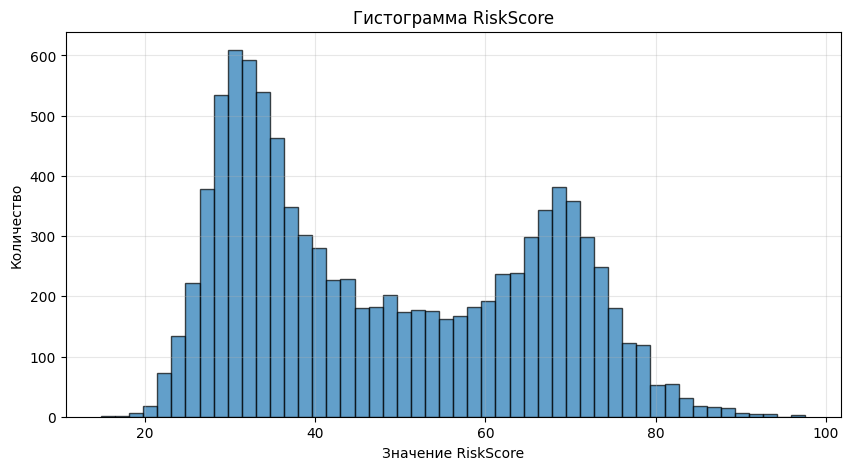

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(y, bins=50, edgecolor='black', alpha=0.7)
plt.title('Гистограмма RiskScore')
plt.xlabel('Значение RiskScore')
plt.ylabel('Количество')
plt.grid(alpha=0.3)
plt.show()

## Анализ типов

Разделяю признаки на числовые и категориальные. Дату обработаю отдельно.

In [35]:
features_train = X.copy(deep=True)
features_test = X_test_raw.copy()

date_col = None
for c in features_train.columns:
    if "date" in c.lower():
        date_col = c
        break

num_features = features_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = features_train.select_dtypes(include=["object", "category"]).columns.tolist()

if date_col and date_col in cat_features:
    cat_features.remove(date_col)

print(f"Числовые: {len(num_features)}, Категориальные: {len(cat_features)}")

Числовые: 28, Категориальные: 5


## Извлечение признаков из даты

Извлекаю год, квартал, месяц и день недели из даты.

In [36]:
def split_date(df, date_col):
    s = pd.to_datetime(df[date_col], errors="coerce")
    return pd.DataFrame({
        "year": s.dt.year,
        "quarter": s.dt.quarter,
        "month": s.dt.month,
        "dow": s.dt.dayofweek
    }, index=df.index)

if date_col:
    dates_train = split_date(features_train, date_col)
    dates_test = split_date(features_test, date_col)
else:
    dates_train = pd.DataFrame(index=features_train.index)
    dates_test = pd.DataFrame(index=features_test.index)

## Подготовка признаков для модели

Тут делаю импьютацию, клиппинг выбросов, стандартизацию. Потом выбираю топ признаков по корреляции и создаю полиномиальные признаки.

In [37]:
def prepare_features(
    features_train: pd.DataFrame,
    features_test: pd.DataFrame,
    num_features,
    cat_features,
    dates_train: pd.DataFrame,
    dates_test: pd.DataFrame,
    y,
    degree: int,
    top_k: int
):
    nums_tr = features_train[num_features].copy()
    nums_te = features_test[num_features].copy()

    imp = SimpleImputer(strategy="median")
    nums_tr_filled = pd.DataFrame(
        imp.fit_transform(nums_tr),
        columns=num_features,
        index=nums_tr.index
    )
    nums_te_filled = pd.DataFrame(
        imp.transform(nums_te),
        columns=num_features,
        index=nums_te.index
    )

    q_low = nums_tr_filled.quantile(0.02)
    q_high = nums_tr_filled.quantile(0.98)

    nums_tr_clipped = nums_tr_filled.clip(lower=q_low, upper=q_high, axis=1)
    nums_te_clipped = nums_te_filled.clip(lower=q_low, upper=q_high, axis=1)

    scaler = StandardScaler()
    nums_tr_norm = pd.DataFrame(
        scaler.fit_transform(nums_tr_clipped),
        columns=num_features,
        index=nums_tr_clipped.index
    )
    nums_te_norm = pd.DataFrame(
        scaler.transform(nums_te_clipped),
        columns=num_features,
        index=nums_te_clipped.index
    )

    corrs = pd.Series(index=num_features, dtype=float)
    for col in num_features:
        try:
            corrs[col] = np.corrcoef(nums_tr_norm[col], y)[0, 1]
        except Exception:
            corrs[col] = 0.0

    feature_corrs = corrs.abs().sort_values(ascending=False)
    top_k = min(top_k, len(feature_corrs))
    top_numeric = feature_corrs.head(top_k).index.tolist()

    if degree is not None and degree > 1:
        poly = PolynomialFeatures(degree=degree, include_bias=False)

        poly_tr = poly.fit_transform(nums_tr_norm[top_numeric])
        poly_te = poly.transform(nums_te_norm[top_numeric])

        poly_cols = poly.get_feature_names_out(top_numeric)

        poly_tr_df = pd.DataFrame(poly_tr, columns=poly_cols, index=nums_tr_norm.index)
        poly_te_df = pd.DataFrame(poly_te, columns=poly_cols, index=nums_te_norm.index)

        rest_nums = [c for c in num_features if c not in top_numeric]
        rest_tr = nums_tr_norm[rest_nums].copy()
        rest_te = nums_te_norm[rest_nums].copy()

        rest_tr = rest_tr.reset_index(drop=True)
        rest_te = rest_te.reset_index(drop=True)
        poly_tr_df = poly_tr_df.reset_index(drop=True)
        poly_te_df = poly_te_df.reset_index(drop=True)
        dates_tr_reset = dates_train.reset_index(drop=True)
        dates_te_reset = dates_test.reset_index(drop=True)
    else:
        poly_tr_df = pd.DataFrame(index=nums_tr_norm.index)
        poly_te_df = pd.DataFrame(index=nums_te_norm.index)
        rest_tr = nums_tr_norm.copy()
        rest_te = nums_te_norm.copy()

        rest_tr = rest_tr.reset_index(drop=True)
        rest_te = rest_te.reset_index(drop=True)
        dates_tr_reset = dates_train.reset_index(drop=True)
        dates_te_reset = dates_test.reset_index(drop=True)

    cats_tr = features_train[cat_features].copy()
    cats_te = features_test[cat_features].copy()

    cats_combined = pd.concat([cats_tr, cats_te], axis=0)
    cats_encoded = pd.get_dummies(cats_combined, drop_first=True)

    cats_tr_encoded = cats_encoded.iloc[:len(cats_tr)].reset_index(drop=True)
    cats_te_encoded = cats_encoded.iloc[len(cats_tr):].reset_index(drop=True)

    final_tr = pd.concat(
        [rest_tr, poly_tr_df, cats_tr_encoded, dates_tr_reset],
        axis=1
    )
    final_te = pd.concat(
        [rest_te, poly_te_df, cats_te_encoded, dates_te_reset],
        axis=1
    )

    return final_tr, final_te, feature_corrs

In [38]:
features_full_train, features_full_test, top_features_corr = prepare_features(
    features_train, features_test, num_features, cat_features,
    dates_train, dates_test, y, POLY_DEGREE, N_TOP_FEATURES
)

print("Размерность train: {}".format(features_full_train.shape))
print("Размерность test: {}".format(features_full_test.shape))

размерность train: (9788, 323)
размерность test: (5000, 323)


## График корреляций признаков

Покажу топ-10 признаков по корреляции с таргетом.

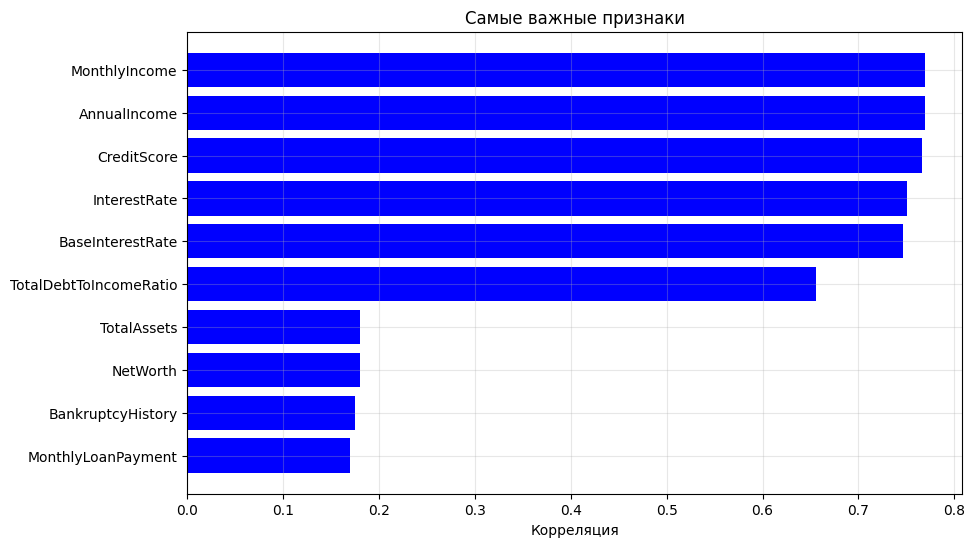

In [39]:
plt.figure(figsize=(10, 6))
top_feats = top_features_corr.head(10)
plt.barh(range(len(top_feats)), top_feats.values, color='blue')
plt.yticks(range(len(top_feats)), top_feats.index)
plt.xlabel('Корреляция')
plt.title('Самые важные признаки')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()

## Сплит данных

Делю данные на обучающую и валидационную выборки.

In [40]:
X_tr, X_val, y_tr, y_val = train_test_split(
    features_full_train, y, test_size=VAL_SPLIT, random_state=SEED
)

print(f"train: {X_tr.shape}, valid: {X_val.shape}")

train: (7830, 323), valid: (1958, 323)


## Тренировка Ridge регрессии

Обучаю Ridge регрессию с подобранными параметрами.

In [57]:
model = Ridge(alpha=RIDGE_ALPHA, random_state=SEED)
model.fit(X_tr, y_tr)

pred_tr = model.predict(X_tr)
pred_val = model.predict(X_val)

mse_tr = mean_squared_error(y_tr, pred_tr)
mse_val = mean_squared_error(y_val, pred_val)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, pred_val)
mape_val = mean_absolute_percentage_error(y_val, pred_val)
r2_val = r2_score(y_val, pred_val)

print("Результаты:")
print(f"MSE (train): {mse_tr:.4f}")
print(f"MSE (valid): {mse_val:.4f}")
print(f"RMSE (valid): {rmse_val:.4f}")
print(f"MAE (valid): {mae_val:.4f}")
print(f"MAPE (valid): {mape_val:.4f}")
print(f"R² (valid): {r2_val:.4f}")
print(f"\nИТОГОВОЕ VALIDATION MSE: {mse_val:.4f}")

Результаты:
MSE (train): 24.5902
MSE (valid): 28.1160
RMSE (valid): 5.3024
MAE (valid): 3.9188
MAPE (valid): 0.0891
R² (valid): 0.9075

ИТОГОВОЕ VALIDATION MSE: 28.1160


## Предсказания для test

In [60]:
pred_test = model.predict(features_full_test)

ex = pd.DataFrame({
    "ID": data_test.index if "ID" not in data_test.columns else data_test["ID"],
    "RiskScore": pred_test
})

ex.to_csv("ex.csv", index=False)
print(ex.head())

   ID  RiskScore
0   0  33.591508
1   1  52.565714
2   2  31.030039
3   3  35.222502
4   4  32.857609


## Финальные результаты


In [62]:
print("Итоговые результаты")
print(f"alpha={RIDGE_ALPHA}, degree={POLY_DEGREE}, top_k={N_TOP_FEATURES}\n")
print(f"Метрики:")
print(f"  MSE:  {mse_val:.4f}")
print(f"  RMSE: {rmse_val:.4f}")
print(f"  MAE:  {mae_val:.4f}")
print(f"  MAPE: {mape_val:.4f}")
print(f"  R²:   {r2_val:.4f}")

Итоговые результаты
alpha=5.0, degree=3, top_k=10

Метрики:
  MSE:  28.1160
  RMSE: 5.3024
  MAE:  3.9188
  MAPE: 0.0891
  R²:   0.9075
